In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import akshare as ak
import json
import os
import time

from datetime import datetime, timedelta
from tqdm import tqdm

from AlphaFactor import calculate_alpha_expression

pd.options.display.max_rows=None
pd.options.display.max_columns=None

In [2]:
# 1. 获取A股所有股票列表
stock_code_list = ak.stock_info_a_code_name()['code']
stock_code_list[:5]

0    000001
1    000002
2    000004
3    000005
4    000006
Name: code, dtype: object

## 1. 获取基础原始数据

In [3]:
def get_stock_indicator_info(stock_code):
    result = ak.stock_a_indicator_lg(symbol=stock_code).rename(columns={
        'trade_date': 'datetime'
    })
    result = result[['datetime', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_mv']]
    return result

def get_stock_individual_info(stock_code):
    result = pd.DataFrame([ak.stock_individual_info_em(symbol=stock_code).set_index('item').to_dict()['value']]).rename(columns={
                    "总市值": "total_market_cap",
                    "流通市值": "circulating_market_cap",
                    "行业": "industry",
                    "上市时间": "listing_date",
                    "股票代码": "stock_code",
                    "股票简称": "stock_name",
                    "总股本": "total_shares",
                    "流通股": "circulating_shares",
                })
    result = result[['stock_code', 'industry', 'total_shares', 'circulating_shares', 'total_market_cap', 'circulating_market_cap']]
    return result

def get_stock_history_info(stock_code):
    """
    前复权（Forward Adjusted）:
    前复权数据将历史价格向前调整，使得最近的价格不变，而历史价格按照股票的分红、送股和转增等因素进行了调整。这种方式使得历史价格反映了如果投资者持有股票至今所应该得到的收益。前复权数据通常用于图表分析，使得价格连续性更好，并且更适用于基于趋势分析的投资策略。

    后复权（Backward Adjusted）:
    后复权数据将历史价格向后调整，使得历史价格保持不变，而最新的价格根据历史的分红和股权变动进行调整。后复权数据通常用于回测，因为它更贴近实际的交易价格，可以较准确地反映历史的交易情况。

    不复权（Unadjusted）:
    不复权数据是指没有经过任何调整的原始交易数据。不复权数据反映了实际的市场成交价格，但由于不考虑分红和股权变动，因此它不适合用于长期的价格分析。
    """
    result = ak.stock_zh_a_hist(symbol=stock_code, adjust='hfq').rename(
            columns={
                "日期": "datetime",
                "开盘": "open",
                "最高": "high",
                "最低": "low",
                "收盘": "close",
                "成交量": "volume",
                "成交额": "turnover",
                "振幅": "amplitude",
                "涨跌幅": "change_pct",
                "涨跌额": "change_amount",
                "换手率": "turnover_rate",
            }
        )
    result = result[['datetime', 'open', 'high', 'low', 'close', 'volume']]
    result.insert(0, 'stock_code', stock_code)
    return result

In [6]:
# init_start_date = '20240226'
raw_data_dir = './raw_data'
for stock_code in tqdm(stock_code_list, desc='Raw Data Extraction...'):
    try:
        save_file_name = f'{stock_code}.pkl'
        if save_file_name not in os.listdir(raw_data_dir):
            r1_info = get_stock_individual_info(stock_code)
            time.sleep(0.1)
            r2_info = get_stock_history_info(stock_code)
            time.sleep(0.1)
            r3_info = get_stock_indicator_info(stock_code)
            time.sleep(0.1)
            if not r1_info.empty and not r2_info.empty and not r3_info.empty:
                merge_info = r1_info.merge(r2_info, on=['stock_code']).merge(r3_info, on=['datetime'])
                merge_info.to_pickle(f'{raw_data_dir}/{save_file_name}')
    except:
        print(f"Stock {stock_code}, build ERROR ...")
        continue

## 2. 原始数据特征变换 & 特征抽取 & 特征工程

In [12]:
def get_label_info(dataframe):
    dataframe = dataframe.sort_values(by=['datetime'])
    # 配置参数
    max_holding_period = 30
    take_profix_threshold = 0.15
    stop_loss_threshold = -0.03
    # 标签初始化
    dataframe['buy_signal'] = 0
    dataframe['buy_take_profix'] = 0
    dataframe['buy_stop_loss'] = 0
    # 标签计算
    for ind in range(len(dataframe) - max_holding_period):
        # 获取当前价格
        current_price = dataframe.iloc[ind]['close']
        
        # 买入点判断
        future_prices = dataframe.iloc[ind + 1:ind + 1 + max_holding_period]['close']
        max_future_return = future_prices.max() / current_price - 1
        min_future_return = future_prices.min() / current_price - 1
        dataframe.at[ind, 'buy_take_profix'] = max_future_return
        dataframe.at[ind, 'buy_stop_loss'] = min_future_return
        if max_future_return >= take_profix_threshold and min_future_return > stop_loss_threshold:
            dataframe.at[ind, 'buy_signal'] = 1
    return dataframe

def get_datetime_info(dataframe):
    datetime_series = pd.to_datetime(dataframe['datetime'])
    dataframe['weekday'] = datetime_series.dt.weekday  # 星期几（0=星期一，6=星期日）
    dataframe['day_of_week'] = datetime_series.dt.day_name()  # 星期几的名称
    dataframe['day_of_month'] = datetime_series.dt.day  # 一个月中的第几天
    dataframe['month'] = datetime_series.dt.month  # 月份
    dataframe['season'] = datetime_series.dt.month.map(lambda x: {
        1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn',
        11: 'Autumn', 12: 'Winter'
    }.get(x))
    return dataframe

def get_vwap_col(dataframe):
    tp = (dataframe['high'] + dataframe['low'] + dataframe['close']) / 3
    tpv = tp * dataframe['volume']
    dataframe['vwap'] = tpv.cumsum() / dataframe['volume'].cumsum()
    return dataframe

def get_factor_info(dataframe, alpha_dict):
    for alpha_name, alpha_expression in alpha_dict.items():
        dataframe[alpha_name] = calculate_alpha_expression(dataframe, alpha_expression)
    return dataframe

In [30]:
wide_data_dir = './wide_data'
alpha_dict = json.loads(open('./alpha_lib.json', "r").read())

for file_name in tqdm(sorted(os.listdir('./raw_data')), desc='Feature Processing...'):
    if file_name not in os.listdir(wide_data_dir):
        df = pd.read_pickle(f'./raw_data/{file_name}')
        df = get_label_info(df)
        df = get_datetime_info(df)
        df = get_vwap_col(df)
        df = get_factor_info(df, alpha_dict)
        df.to_pickle(f'{wide_data_dir}/{file_name}')

Feature Processing...:   0%|          | 0/4586 [00:00<?, ?it/s]

Feature Processing...:   7%|▋         | 327/4586 [46:50<10:10:03,  8.59s/it]  


KeyboardInterrupt: 

## 3. 特征数据整合

In [3]:
stock_wide_list = []
for file_name in tqdm(os.listdir('./wide_data'), desc='Loading Stock...'):
    stock_data = pd.read_pickle(f'./wide_data/{file_name}')
    stock_wide_list.append(stock_data)
df = pd.concat(stock_wide_list)
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df['datetime'] = pd.to_datetime(df['datetime'])

Loading Stock...:   0%|          | 0/327 [00:00<?, ?it/s]

Loading Stock...: 100%|██████████| 327/327 [00:07<00:00, 45.75it/s]


In [37]:
# df.head()

In [ ]:
timedelta()

## 4. 模型训练

In [4]:
# 6. 选择固定时间区间的数据
train_start_date = pd.to_datetime('2018-01-01')
train_end_date = pd.to_datetime('2021-12-31')
val_start_date = pd.to_datetime('2022-01-01')
val_end_date = pd.to_datetime('2022-04-01')

train_data = df[(df['datetime'] >= train_start_date) & (df['datetime'] <= train_end_date)]
validation_data = df[(df['datetime'] >= val_start_date) & (df['datetime'] <= val_end_date)]

In [5]:
label_column = 'buy_signal'

train_0, train_1 = np.bincount(train_data[label_column])
train_total = train_0 + train_1
print('Train:\nTotal: {}, Normal: {}, Positive: {} \n'.format(train_total, train_0, train_1))
val_0, val_1 = np.bincount(validation_data[label_column])
val_total = val_0 + val_1
print('Validation:\nTotal: {}, Normal: {},Positive: {} \n'.format(val_total, val_0, val_1))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / train_0) * (train_total / 2.0)
weight_for_1 = (1 / train_1) * (train_total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Train:
Total: 254742, Normal: 218772, Positive: 35970 

Validation:
Total: 14023, Normal: 13276,Positive: 747 

Weight for class 0: 0.58
Weight for class 1: 3.54


## 尝试使用LightGBM

In [6]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

lgb_train_data = train_data.copy()
lgb_val_data = validation_data.copy()

label_col = 'buy_signal'
numeric_features = ["KMID", "KLEN", "KMID2", "KUP", "KUP2", "KLOW", "KLOW2", "KSFT", "KSFT2", "OPEN0", "OPEN1", "OPEN2", "OPEN3", "OPEN4", "HIGH0", "HIGH1", "HIGH2", "HIGH3", "HIGH4", "LOW0", "LOW1", "LOW2", "LOW3", "LOW4", "CLOSE0", "CLOSE1", "CLOSE2", "CLOSE3", "CLOSE4", "VWAP0", "VWAP1", "VWAP2", "VWAP3", "VWAP4", "VOLUME0", "VOLUME1", "VOLUME2", "VOLUME3", "VOLUME4", "ROC5", "ROC10", "ROC20", "ROC30", "ROC60", "MAX5", "MAX10", "MAX20", "MAX30", "MAX60", "MIN5", "MIN10", "MIN20", "MIN30", "MIN60", "MA5", "MA10", "MA20", "MA30", "MA60", "STD5", "STD10", "STD20", "STD30", "STD60", "BETA5", "BETA10", "BETA20", "BETA30", "BETA60", 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', "RSQR5", "RSQR10", "RSQR20", "RSQR30", "RSQR60", "RESI5", "RESI10", "RESI20", "RESI30", "RESI60", "QTLU5", "QTLU10", "QTLU20", "QTLU30", "QTLU60", "QTLD5", "QTLD10", "QTLD20", "QTLD30", "QTLD60", "RSV5", "RSV10", "RSV20", "RSV30", "RSV60", "IMAX5", "IMAX10", "IMAX20", "IMAX30", "IMAX60", "IMIN5", "IMIN10", "IMIN20", "IMIN30", "IMIN60", "IMXD5", "IMXD10", "IMXD20", "IMXD30", "IMXD60", "CORR5", "CORR10", "CORR20", "CORR30", "CORR60", "CORD5", "CORD10", "CORD20", "CORD30", "CORD60", "CNTP5", "CNTP10", "CNTP20", "CNTP30", "CNTP60", "CNTN5", "CNTN10", "CNTN20", "CNTN30", "CNTN60", "CNTD5", "CNTD10", "CNTD20", "CNTD30", "CNTD60", "SUMP5", "SUMP10", "SUMP20", "SUMP30", "SUMP60", "SUMN5", "SUMN10", "SUMN20", "SUMN30", "SUMN60", "SUMD5", "SUMD10", "SUMD20", "SUMD30", "SUMD60", "VMA5", "VMA10", "VMA20", "VMA30", "VMA60", "VSTD5", "VSTD10", "VSTD20", "VSTD30", "VSTD60", "WVMA5", "WVMA10", "WVMA20", "WVMA30", "WVMA60", "VSUMP5", "VSUMP10", "VSUMP20", "VSUMP30", "VSUMP60", "VSUMN5", "VSUMN10", "VSUMN20", "VSUMN30", "VSUMN60", "VSUMD5", "VSUMD10", "VSUMD20", "VSUMD30", "VSUMD60"]
# category_features = ['industry', 'day_of_week', 'season', 'weekday', 'day_of_month', 'month']
category_features = []
feature_names = category_features + numeric_features

for cat_feas in category_features:
    lgb_train_data[cat_feas] = lgb_train_data[cat_feas].astype('category')
    lgb_val_data[cat_feas] = lgb_val_data[cat_feas].astype('category')

X_train, y_train = lgb_train_data[feature_names], lgb_train_data[label_col]
X_val, y_val = lgb_val_data[feature_names], lgb_val_data[label_col]

In [7]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(2, interaction_only=True)
# X_poly_train = poly.fit_transform(X_train)

In [8]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# 网格搜索，参数优化
# estimator = LGBMClassifier(num_leaves=201, class_weight=class_weight)
# param_grid = {
#     'learning_rate': [0.01, 0.1, 1],
#     'n_estimators': [300, 500, 1000]
# }
# gbm = GridSearchCV(estimator, param_grid)
# gbm.fit(X_train, y_train)
# print('Best parameters found by grid search are:', gbm.best_params_)

# 模型训练
gbm = LGBMClassifier(num_leaves=201, learning_rate=0.01, n_estimators=1000, is_unbalance=True, random_state=42)
# gbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc', callbacks=[lgb.early_stopping(1000)])
gbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc')

# 使用 predict 方法获取预测的类别标签
y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration_)
# 使用 predict_proba 方法获取属于正类的预测概率
y_val_prob = gbm.predict_proba(X_val)[:, 1]

# 计算准确率
print(f'Accuracy: {accuracy_score(y_val, y_val_pred)}')
print(f'Precision: {precision_score(y_val, y_val_pred)}')
print(f'Recall: {recall_score(y_val, y_val_pred)}')
print(f'AUC: {roc_auc_score(y_val, y_val_prob)}')

[LightGBM] [Info] Number of positive: 35970, number of negative: 218772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38640
[LightGBM] [Info] Number of data points in the train set: 254742, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141202 -> initscore=-1.805345
[LightGBM] [Info] Start training from score -1.805345
Accuracy: 0.7514084004849176
Precision: 0.08512571947894577
Recall: 0.37617135207496655
AUC: 0.6178427680794485


In [9]:
test_df = validation_data[['buy_signal', 'buy_take_profix', 'buy_stop_loss']]
test_df['pred'] = y_val_pred
test_df['prob'] = y_val_prob
test_df.sort_values(by='prob', ascending=False).head(20)

,buy_signal,buy_take_profix,buy_stop_loss,pred,prob
5006,0,0.198582,-0.117730,1,0.875562
4983,1,0.649165,0.068417,1,0.872675
4982,1,0.656941,0.068272,1,0.868918
5127,0,0.086993,-0.173000,1,0.861583
5104,0,0.091569,-0.084543,1,0.854561
5100,0,0.092888,-0.098694,1,0.849968
5132,0,0.043965,-0.241890,1,0.835068
5104,0,0.083647,-0.265161,1,0.834318
5099,0,0.159353,-0.043880,1,0.828681
4882,0,0.196259,-0.126593,1,0.823394


In [119]:
# 特征重要度
feature_importance = sorted(zip(feature_names, gbm.feature_importances_), key=lambda x:x[1], reverse=True)
print('Feature importances:',feature_importance)

Feature importances: [('CORR60', 14), ('WVMA60', 12), ('STD60', 10), ('CORD60', 10), ('IMXD60', 8), ('STD20', 7), ('RSQR60', 7), ('IMIN60', 7), ('VWAP0', 6), ('WVMA20', 6), ('CORD20', 5), ('CORD30', 5), ('BETA60', 4), ('QTLD60', 4), ('IMIN20', 4), ('CORR20', 4), ('SUMN60', 4), ('VWAP1', 3), ('VWAP4', 3), ('MAX20', 3), ('MIN60', 3), ('BETA30', 3), ('QTLU60', 3), ('VSTD30', 3), ('VWAP3', 2), ('ROC60', 2), ('MAX30', 2), ('MIN20', 2), ('STD5', 2), ('STD10', 2), ('STD30', 2), ('BETA20', 2), ('RESI60', 2), ('QTLU20', 2), ('CORR30', 2), ('CORD10', 2), ('CNTD60', 2), ('VSTD60', 2), ('VSUMP60', 2), ('VSUMN60', 2), ('LOW3', 1), ('VWAP2', 1), ('MAX10', 1), ('MAX60', 1), ('MIN5', 1), ('MIN30', 1), ('MA10', 1), ('MA20', 1), ('MA30', 1), ('MA60', 1), ('RSQR20', 1), ('RSQR30', 1), ('RESI30', 1), ('QTLD10', 1), ('QTLD20', 1), ('IMAX30', 1), ('IMIN30', 1), ('CNTP20', 1), ('CNTP60', 1), ('CNTN60', 1), ('CNTD30', 1), ('SUMP60', 1), ('SUMD30', 1), ('SUMD60', 1), ('VMA30', 1), ('VSTD10', 1), ('WVMA10', 1),

179

## 使用Tensorflow

In [ ]:
# 使用tensorflow处理原始数据
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

In [ ]:
def get_numeric_boundaries(series, num_bins=40):
    boundaries = pd.qcut(series, num_bins, retbins=True, duplicates='drop')[1].tolist()
    return boundaries

TARGET_FEATURE_NAME = "label1"

# 连续特征分桶
NUMERIC_FEATURES = {
    'total_shares': get_numeric_boundaries(train_data['total_shares']),
    'circulating_shares': get_numeric_boundaries(train_data['circulating_shares']),
    'total_market_cap': get_numeric_boundaries(train_data['total_market_cap']),
    'circulating_market_cap': get_numeric_boundaries(train_data['circulating_market_cap']),
    'turnover_rate': get_numeric_boundaries(train_data['turnover_rate']),
    'pe': get_numeric_boundaries(train_data['pe']),
    'pe_ttm': get_numeric_boundaries(train_data['pe_ttm']),
    'pb': get_numeric_boundaries(train_data['pb']),
    'ps': get_numeric_boundaries(train_data['ps']),
    'ps_ttm': get_numeric_boundaries(train_data['ps_ttm']),
    'total_mv': get_numeric_boundaries(train_data['total_mv']),
    "KMID": get_numeric_boundaries(train_data["KMID"]),
    "KLEN": get_numeric_boundaries(train_data["KLEN"]),
    "KMID2": get_numeric_boundaries(train_data["KMID2"]),
    "KUP": get_numeric_boundaries(train_data["KUP"]),
    "KUP2": get_numeric_boundaries(train_data["KUP2"]),
    "KLOW": get_numeric_boundaries(train_data["KLOW"]),
    "KLOW2": get_numeric_boundaries(train_data["KLOW2"]),
    "KSFT": get_numeric_boundaries(train_data["KSFT"]),
    "KSFT2": get_numeric_boundaries(train_data["KSFT2"]),
    "OPEN0": get_numeric_boundaries(train_data["OPEN0"]),
    "OPEN1": get_numeric_boundaries(train_data["OPEN1"]),
    "OPEN2": get_numeric_boundaries(train_data["OPEN2"]),
    "OPEN3": get_numeric_boundaries(train_data["OPEN3"]),
    "OPEN4": get_numeric_boundaries(train_data["OPEN4"]),
    "HIGH0": get_numeric_boundaries(train_data["HIGH0"]),
    "HIGH1": get_numeric_boundaries(train_data["HIGH1"]),
    "HIGH2": get_numeric_boundaries(train_data["HIGH2"]),
    "HIGH3": get_numeric_boundaries(train_data["HIGH3"]),
    "HIGH4": get_numeric_boundaries(train_data["HIGH4"]),
    "LOW0": get_numeric_boundaries(train_data["LOW0"]),
    "LOW1": get_numeric_boundaries(train_data["LOW1"]),
    "LOW2": get_numeric_boundaries(train_data["LOW2"]),
    "LOW3": get_numeric_boundaries(train_data["LOW3"]),
    "LOW4": get_numeric_boundaries(train_data["LOW4"]),
    "CLOSE0": get_numeric_boundaries(train_data["CLOSE0"]),
    "CLOSE1": get_numeric_boundaries(train_data["CLOSE1"]),
    "CLOSE2": get_numeric_boundaries(train_data["CLOSE2"]),
    "CLOSE3": get_numeric_boundaries(train_data["CLOSE3"]),
    "CLOSE4": get_numeric_boundaries(train_data["CLOSE4"]),
    "VWAP0": get_numeric_boundaries(train_data["VWAP0"]),
    "VWAP1": get_numeric_boundaries(train_data["VWAP1"]),
    "VWAP2": get_numeric_boundaries(train_data["VWAP2"]),
    "VWAP3": get_numeric_boundaries(train_data["VWAP3"]),
    "VWAP4": get_numeric_boundaries(train_data["VWAP4"]),
    "VOLUME0": get_numeric_boundaries(train_data["VOLUME0"]),
    "VOLUME1": get_numeric_boundaries(train_data["VOLUME1"]),
    "VOLUME2": get_numeric_boundaries(train_data["VOLUME2"]),
    "VOLUME3": get_numeric_boundaries(train_data["VOLUME3"]),
    "VOLUME4": get_numeric_boundaries(train_data["VOLUME4"]),
    "ROC5": get_numeric_boundaries(train_data["ROC5"]),
    "ROC10": get_numeric_boundaries(train_data["ROC10"]),
    "ROC20": get_numeric_boundaries(train_data["ROC20"]),
    "ROC30": get_numeric_boundaries(train_data["ROC30"]),
    "ROC60": get_numeric_boundaries(train_data["ROC60"]),
    "MAX5": get_numeric_boundaries(train_data["MAX5"]),
    "MAX10": get_numeric_boundaries(train_data["MAX10"]),
    "MAX20": get_numeric_boundaries(train_data["MAX20"]),
    "MAX30": get_numeric_boundaries(train_data["MAX30"]),
    "MAX60": get_numeric_boundaries(train_data["MAX60"]),
    "MIN5": get_numeric_boundaries(train_data["MIN5"]),
    "MIN10": get_numeric_boundaries(train_data["MIN10"]),
    "MIN20": get_numeric_boundaries(train_data["MIN20"]),
    "MIN30": get_numeric_boundaries(train_data["MIN30"]),
    "MIN60": get_numeric_boundaries(train_data["MIN60"]),
    "MA5": get_numeric_boundaries(train_data["MA5"]),
    "MA10": get_numeric_boundaries(train_data["MA10"]),
    "MA20": get_numeric_boundaries(train_data["MA20"]),
    "MA30": get_numeric_boundaries(train_data["MA30"]),
    "MA60": get_numeric_boundaries(train_data["MA60"]),
    "STD5": get_numeric_boundaries(train_data["STD5"]),
    "STD10": get_numeric_boundaries(train_data["STD10"]),
    "STD20": get_numeric_boundaries(train_data["STD20"]),
    "STD30": get_numeric_boundaries(train_data["STD30"]),
    "STD60": get_numeric_boundaries(train_data["STD60"]),
    "BETA5": get_numeric_boundaries(train_data["BETA5"]),
    "BETA10": get_numeric_boundaries(train_data["BETA10"]),
    "BETA20": get_numeric_boundaries(train_data["BETA20"]),
    "BETA30": get_numeric_boundaries(train_data["BETA30"]),
    "BETA60": get_numeric_boundaries(train_data["BETA60"]),
    "RSQR5": get_numeric_boundaries(train_data["RSQR5"]),
    "RSQR10": get_numeric_boundaries(train_data["RSQR10"]),
    "RSQR20": get_numeric_boundaries(train_data["RSQR20"]),
    "RSQR30": get_numeric_boundaries(train_data["RSQR30"]),
    "RSQR60": get_numeric_boundaries(train_data["RSQR60"]),
    "RESI5": get_numeric_boundaries(train_data["RESI5"]),
    "RESI10": get_numeric_boundaries(train_data["RESI10"]),
    "RESI20": get_numeric_boundaries(train_data["RESI20"]),
    "RESI30": get_numeric_boundaries(train_data["RESI30"]),
    "RESI60": get_numeric_boundaries(train_data["RESI60"]),
    "QTLU5": get_numeric_boundaries(train_data["QTLU5"]),
    "QTLU10": get_numeric_boundaries(train_data["QTLU10"]),
    "QTLU20": get_numeric_boundaries(train_data["QTLU20"]),
    "QTLU30": get_numeric_boundaries(train_data["QTLU30"]),
    "QTLU60": get_numeric_boundaries(train_data["QTLU60"]),
    "QTLD5": get_numeric_boundaries(train_data["QTLD5"]),
    "QTLD10": get_numeric_boundaries(train_data["QTLD10"]),
    "QTLD20": get_numeric_boundaries(train_data["QTLD20"]),
    "QTLD30": get_numeric_boundaries(train_data["QTLD30"]),
    "QTLD60": get_numeric_boundaries(train_data["QTLD60"]),
    # "TSRANK5": get_numeric_boundaries(train_data["TSRANK5"]),
    # "TSRANK10": get_numeric_boundaries(train_data["TSRANK10"]),
    # "TSRANK20": get_numeric_boundaries(train_data["TSRANK20"]),
    # "TSRANK30": get_numeric_boundaries(train_data["TSRANK30"]),
    # "TSRANK60": get_numeric_boundaries(train_data["TSRANK60"]),
    "RSV5": get_numeric_boundaries(train_data["RSV5"]),
    "RSV10": get_numeric_boundaries(train_data["RSV10"]),
    "RSV20": get_numeric_boundaries(train_data["RSV20"]),
    "RSV30": get_numeric_boundaries(train_data["RSV30"]),
    "RSV60": get_numeric_boundaries(train_data["RSV60"]),
    "IMAX5": get_numeric_boundaries(train_data["IMAX5"]),
    "IMAX10": get_numeric_boundaries(train_data["IMAX10"]),
    "IMAX20": get_numeric_boundaries(train_data["IMAX20"]),
    "IMAX30": get_numeric_boundaries(train_data["IMAX30"]),
    "IMAX60": get_numeric_boundaries(train_data["IMAX60"]),
    "IMIN5": get_numeric_boundaries(train_data["IMIN5"]),
    "IMIN10": get_numeric_boundaries(train_data["IMIN10"]),
    "IMIN20": get_numeric_boundaries(train_data["IMIN20"]),
    "IMIN30": get_numeric_boundaries(train_data["IMIN30"]),
    "IMIN60": get_numeric_boundaries(train_data["IMIN60"]),
    "IMXD5": get_numeric_boundaries(train_data["IMXD5"]),
    "IMXD10": get_numeric_boundaries(train_data["IMXD10"]),
    "IMXD20": get_numeric_boundaries(train_data["IMXD20"]),
    "IMXD30": get_numeric_boundaries(train_data["IMXD30"]),
    "IMXD60": get_numeric_boundaries(train_data["IMXD60"]),
    "CORR5": get_numeric_boundaries(train_data["CORR5"]),
    "CORR10": get_numeric_boundaries(train_data["CORR10"]),
    "CORR20": get_numeric_boundaries(train_data["CORR20"]),
    "CORR30": get_numeric_boundaries(train_data["CORR30"]),
    "CORR60": get_numeric_boundaries(train_data["CORR60"]),
    "CORD5": get_numeric_boundaries(train_data["CORD5"]),
    "CORD10": get_numeric_boundaries(train_data["CORD10"]),
    "CORD20": get_numeric_boundaries(train_data["CORD20"]),
    "CORD30": get_numeric_boundaries(train_data["CORD30"]),
    "CORD60": get_numeric_boundaries(train_data["CORD60"]),
    "CNTP5": get_numeric_boundaries(train_data["CNTP5"]),
    "CNTP10": get_numeric_boundaries(train_data["CNTP10"]),
    "CNTP20": get_numeric_boundaries(train_data["CNTP20"]),
    "CNTP30": get_numeric_boundaries(train_data["CNTP30"]),
    "CNTP60": get_numeric_boundaries(train_data["CNTP60"]),
    "CNTN5": get_numeric_boundaries(train_data["CNTN5"]),
    "CNTN10": get_numeric_boundaries(train_data["CNTN10"]),
    "CNTN20": get_numeric_boundaries(train_data["CNTN20"]),
    "CNTN30": get_numeric_boundaries(train_data["CNTN30"]),
    "CNTN60": get_numeric_boundaries(train_data["CNTN60"]),
    "CNTD5": get_numeric_boundaries(train_data["CNTD5"]),
    "CNTD10": get_numeric_boundaries(train_data["CNTD10"]),
    "CNTD20": get_numeric_boundaries(train_data["CNTD20"]),
    "CNTD30": get_numeric_boundaries(train_data["CNTD30"]),
    "CNTD60": get_numeric_boundaries(train_data["CNTD60"]),
    "SUMP5": get_numeric_boundaries(train_data["SUMP5"]),
    "SUMP10": get_numeric_boundaries(train_data["SUMP10"]),
    "SUMP20": get_numeric_boundaries(train_data["SUMP20"]),
    "SUMP30": get_numeric_boundaries(train_data["SUMP30"]),
    "SUMP60": get_numeric_boundaries(train_data["SUMP60"]),
    "SUMN5": get_numeric_boundaries(train_data["SUMN5"]),
    "SUMN10": get_numeric_boundaries(train_data["SUMN10"]),
    "SUMN20": get_numeric_boundaries(train_data["SUMN20"]),
    "SUMN30": get_numeric_boundaries(train_data["SUMN30"]),
    "SUMN60": get_numeric_boundaries(train_data["SUMN60"]),
    "SUMD5": get_numeric_boundaries(train_data["SUMD5"]),
    "SUMD10": get_numeric_boundaries(train_data["SUMD10"]),
    "SUMD20": get_numeric_boundaries(train_data["SUMD20"]),
    "SUMD30": get_numeric_boundaries(train_data["SUMD30"]),
    "SUMD60": get_numeric_boundaries(train_data["SUMD60"]),
    "VMA5": get_numeric_boundaries(train_data["VMA5"]),
    "VMA10": get_numeric_boundaries(train_data["VMA10"]),
    "VMA20": get_numeric_boundaries(train_data["VMA20"]),
    "VMA30": get_numeric_boundaries(train_data["VMA30"]),
    "VMA60": get_numeric_boundaries(train_data["VMA60"]),
    "VSTD5": get_numeric_boundaries(train_data["VSTD5"]),
    "VSTD10": get_numeric_boundaries(train_data["VSTD10"]),
    "VSTD20": get_numeric_boundaries(train_data["VSTD20"]),
    "VSTD30": get_numeric_boundaries(train_data["VSTD30"]),
    "VSTD60": get_numeric_boundaries(train_data["VSTD60"]),
    "WVMA5": get_numeric_boundaries(train_data["WVMA5"]),
    "WVMA10": get_numeric_boundaries(train_data["WVMA10"]),
    "WVMA20": get_numeric_boundaries(train_data["WVMA20"]),
    "WVMA30": get_numeric_boundaries(train_data["WVMA30"]),
    "WVMA60": get_numeric_boundaries(train_data["WVMA60"]),
    "VSUMP5": get_numeric_boundaries(train_data["VSUMP5"]),
    "VSUMP10": get_numeric_boundaries(train_data["VSUMP10"]),
    "VSUMP20": get_numeric_boundaries(train_data["VSUMP20"]),
    "VSUMP30": get_numeric_boundaries(train_data["VSUMP30"]),
    "VSUMP60": get_numeric_boundaries(train_data["VSUMP60"]),
    "VSUMN5": get_numeric_boundaries(train_data["VSUMN5"]),
    "VSUMN10": get_numeric_boundaries(train_data["VSUMN10"]),
    "VSUMN20": get_numeric_boundaries(train_data["VSUMN20"]),
    "VSUMN30": get_numeric_boundaries(train_data["VSUMN30"]),
    "VSUMN60": get_numeric_boundaries(train_data["VSUMN60"]),
    "VSUMD5": get_numeric_boundaries(train_data["VSUMD5"]),
    "VSUMD10": get_numeric_boundaries(train_data["VSUMD10"]),
    "VSUMD20": get_numeric_boundaries(train_data["VSUMD20"]),
    "VSUMD30": get_numeric_boundaries(train_data["VSUMD30"]),
    "VSUMD60": get_numeric_boundaries(train_data["VSUMD60"]),
}

# 离散特征embedding
INTEGER_CATEGORICAL_FEATURES = {
    'weekday': train_data['weekday'].unique().tolist(),
    'day_of_month': train_data['day_of_month'].unique().tolist(),
    'month': train_data['month'].unique().tolist(),
    # 'TSRANK5': train_data['TSRANK5'].unique().tolist(),
    # 'TSRANK10': train_data['TSRANK10'].unique().tolist(),
    # 'TSRANK20': train_data['TSRANK20'].unique().tolist(),
    # 'TSRANK30': train_data['TSRANK30'].unique().tolist(),
    # 'TSRANK60': train_data['TSRANK60'].unique().tolist(),
}
STRING_CATEGORICAL_FEATURES = {
    'industry': train_data['industry'].unique().tolist(),
    'day_of_week': train_data['day_of_week'].unique().tolist(),
    'season': train_data['season'].unique().tolist(),
}


FEATURE_NAMES = list(NUMERIC_FEATURES.keys()) + list(INTEGER_CATEGORICAL_FEATURES.keys()) + list(STRING_CATEGORICAL_FEATURES.keys())

In [31]:
BATCH_SIZE = 128

def df_to_dataset(dataframe, shuffle=True):
  # dataframe = dataframe.drop('datetime', axis=1)
  labels = dataframe[TARGET_FEATURE_NAME]
  dataframe = dataframe[FEATURE_NAMES]
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(BATCH_SIZE)
  return ds

train_ds = df_to_dataset(train_data, shuffle=True)
val_ds = df_to_dataset(validation_data, shuffle=False)
test_ds = df_to_dataset(test_data, shuffle=False)

In [32]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        elif feature_name in INTEGER_CATEGORICAL_FEATURES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="int32"
            )
        else:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="string"
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    embedding_dim = 6
    is_embedding = True

    # 处理连续特征
    for feature_name, boundaries in NUMERIC_FEATURES.items():
        if is_embedding:
            lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='int')
            embedding = tf.keras.layers.Embedding(
                input_dim=len(boundaries) + 1, output_dim=embedding_dim
            )
            encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        else:
            lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='one_hot')
            encoded_feature = lookup_layer(inputs[feature_name])
        encoded_features.append(encoded_feature)

    # 处理INTEGER离散特征
    for feature_name, integer_vocab in INTEGER_CATEGORICAL_FEATURES.items():
        lookup_layer = tf.keras.layers.IntegerLookup(vocabulary=integer_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(integer_vocab) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    # 处理STRING离散特征
    for feature_name, string_vocab in STRING_CATEGORICAL_FEATURES.items():
        lookup_layer = tf.keras.layers.StringLookup(vocabulary=string_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(string_vocab) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    print(f"Total Features Size:: {len(encoded_features)}")
    all_features = tf.keras.layers.concatenate(encoded_features)
    return all_features

In [33]:
LEARNING_RATE = 5e-3
NUM_EPOCH = 20

def run_experiment(model, train_ds, val_ds, test_ds):
    # optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE) # for mac M1/M2
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # for mac M1/M2
    
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
        
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True,
    )
    print("Start training the model...")
    history = model.fit(
        train_ds, 
        epochs=NUM_EPOCH,
        validation_data=val_ds, 
        verbose=2,
        callbacks=[early_stopping],
        class_weight=class_weight
    )
    print("Model training finished")

    # loss, auc = model.evaluate(test_ds, verbose=0)
    # print(f"Test AUC::{round(auc * 100, 2)}%")

In [34]:
dropout_rate = 0.2
hidden_units = [128, 32]

In [35]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = tf.keras.layers.Dense(units)(features)
        features = tf.keras.layers.BatchNormalization()(features)
        features = tf.keras.layers.ReLU()(features)
        features = tf.keras.layers.Dropout(dropout_rate)(features)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

baseline_model = create_baseline_model()
# tf.keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")
run_experiment(baseline_model, train_ds, val_ds, test_ds)

Total Features Size:: 196
Start training the model...
Epoch 1/20
879/879 - 53s - loss: 0.6766 - tp: 19124.0000 - fp: 34636.0000 - tn: 45405.0000 - fn: 13300.0000 - accuracy: 0.5738 - precision: 0.3557 - recall: 0.5898 - auc: 0.6080 - val_loss: 0.6920 - val_tp: 1801.0000 - val_fp: 4452.0000 - val_tn: 4455.0000 - val_fn: 1178.0000 - val_accuracy: 0.5263 - val_precision: 0.2880 - val_recall: 0.6046 - val_auc: 0.5721 - 53s/epoch - 60ms/step
Epoch 2/20
879/879 - 24s - loss: 0.6381 - tp: 21462.0000 - fp: 31439.0000 - tn: 48602.0000 - fn: 10962.0000 - accuracy: 0.6230 - precision: 0.4057 - recall: 0.6619 - auc: 0.6850 - val_loss: 0.7583 - val_tp: 1899.0000 - val_fp: 4828.0000 - val_tn: 4079.0000 - val_fn: 1080.0000 - val_accuracy: 0.5029 - val_precision: 0.2823 - val_recall: 0.6375 - val_auc: 0.5596 - 24s/epoch - 28ms/step
Epoch 3/20
879/879 - 25s - loss: 0.6027 - tp: 22606.0000 - fp: 28416.0000 - tn: 51625.0000 - fn: 9818.0000 - accuracy: 0.6600 - precision: 0.4431 - recall: 0.6972 - auc: 0.

2024-02-23 16:41:25.714555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 102318 of 112465
2024-02-23 16:41:26.773264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


879/879 - 29s - loss: 0.5095 - tp: 25253.0000 - fp: 22573.0000 - tn: 57468.0000 - fn: 7171.0000 - accuracy: 0.7355 - precision: 0.5280 - recall: 0.7788 - auc: 0.8266 - val_loss: 0.7876 - val_tp: 1569.0000 - val_fp: 3948.0000 - val_tn: 4959.0000 - val_fn: 1410.0000 - val_accuracy: 0.5492 - val_precision: 0.2844 - val_recall: 0.5267 - val_auc: 0.5581 - 29s/epoch - 33ms/step
Epoch 6/20
879/879 - 27s - loss: 0.4581 - tp: 26309.0000 - fp: 19606.0000 - tn: 60435.0000 - fn: 6115.0000 - accuracy: 0.7713 - precision: 0.5730 - recall: 0.8114 - auc: 0.8641 - val_loss: 0.8215 - val_tp: 1571.0000 - val_fp: 3954.0000 - val_tn: 4953.0000 - val_fn: 1408.0000 - val_accuracy: 0.5489 - val_precision: 0.2843 - val_recall: 0.5274 - val_auc: 0.5575 - 27s/epoch - 30ms/step
Epoch 7/20
879/879 - 27s - loss: 0.4109 - tp: 27103.0000 - fp: 16927.0000 - tn: 63114.0000 - fn: 5321.0000 - accuracy: 0.8022 - precision: 0.6156 - recall: 0.8359 - auc: 0.8931 - val_loss: 0.8674 - val_tp: 1448.0000 - val_fp: 3820.0000 - v

In [36]:
# baseline_model.save('./stock_selection_base_model')
# reloaded_model = tf.keras.models.load_model('./stock_selection_base_model')

In [37]:
# samples = df_to_dataset(test_data.iloc[:100, :], shuffle=False, batch_size=10)

In [38]:
test_labels = []
for _, labels in test_ds:
    test_labels.extend(labels.numpy())

test_predictions = baseline_model.predict(test_ds).squeeze()

94/94 [==============================] - 4s 20ms/step


In [39]:
test_df = pd.DataFrame()
test_df['true_label'] = test_labels
test_df['prediction'] = test_predictions

In [ ]:
# 预测最高的打分，实际label都不是1
test_df.sort_values(by='prediction', ascending=False).head(20)

,true_label,prediction
5441,1,0.846764
1407,0,0.793685
5702,0,0.782062
10277,0,0.778084
7699,1,0.776973
8181,1,0.772075
6754,0,0.771943
7842,1,0.766099
6718,0,0.765828
7936,0,0.763873


In [40]:
# import matplotlib.pyplot as plt

# plt.hist(true_positives_scores, bins=50, alpha=0.5, label='True Positives')
# plt.hist(false_positives_scores, bins=50, alpha=0.5, label='False Positives')
# plt.xlabel('Scores')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

Legitimate Transactions Detected (True Negatives):  3647
Legitimate Transactions Incorrectly Detected (False Positives):  5345
Fraudulent Transactions Missed (False Negatives):  946
Fraudulent Transactions Detected (True Positives):  2069
Total Fraudulent Transactions:  3015


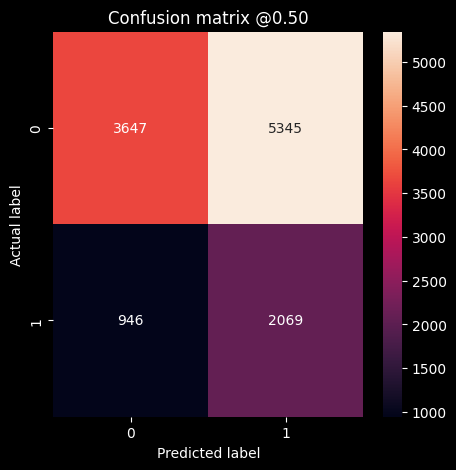

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

plot_cm(test_labels, test_predictions)
